In [16]:
from dipy.data import get_sphere
from microstruktur.distributions import distributions
import numpy as np
from dipy.reconst.shm import real_sym_sh_mrtrix
import matplotlib.pyplot as plt
%matplotlib inline 
watson = distributions.SD1Watson()
bingham = distributions.SD2Bingham()

# Test what spherical harmonic order is needed to represent a watson distribution for a certain ODI

In [3]:
# estimate what spherical harmonic order is sufficient for a certain kappa
mu = np.r_[0., 0.]
odis = np.linspace(0.04, 1., 100)
sh_orders = np.arange(2, 15, 2)

error_results = np.zeros((len(odis), len(sh_orders)))
sphere = get_sphere().subdivide()

for i, odi in enumerate(odis):
    for j, sh_order in enumerate(sh_orders):
        watson_sf = watson(sphere.vertices, mu=mu, odi=odi)
        sh_mat = real_sym_sh_mrtrix(sh_order, sphere.theta, sphere.phi)[0]
        sh_mat_inv = np.linalg.pinv(sh_mat)
        watson_sh = np.dot(sh_mat_inv, watson_sf)
        watson_rec = np.dot(sh_mat, watson_sh)
        error_results[i, j] = max(np.abs(watson_sf - watson_rec) / max(watson_sf))

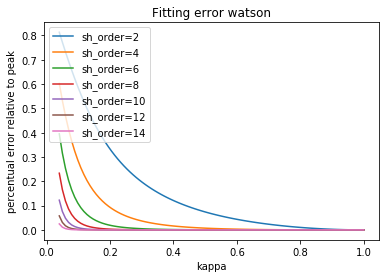

In [4]:
for i, sh_order in enumerate(sh_orders):
    plt.plot(odis, error_results[:, i],
             label='sh_order=' + str(sh_order))
plt.title('Fitting error watson')
plt.xlabel('kappa')
plt.ylabel('percentual error relative to peak')
plt.legend(loc='upper left')

In [6]:
sh_order_odis = odis[np.argmax(error_results < 0.01, axis=0)]
sh_order_odis

array([ 0.80606061,  0.46666667,  0.25333333,  0.15636364,  0.09818182,
        0.06909091,  0.05939394])

In [39]:
def get_sh_order_from_odi(odi):
    odis = np.array([0.80606061,  0.46666667,  0.25333333,  0.15636364,  0.09818182,
        0.06909091,  0.])
    sh_orders = np.arange(2, 15, 2)
    return sh_orders[np.argmax(odis < odi)]

# Same for Bingham

In [20]:
# estimate what spherical harmonic order is sufficient for a certain kappa
mu = np.r_[0., 0.]
odis = np.linspace(0.04, 1., 100)
beta_fraction = 0.
psi = 0.
sh_orders = np.arange(2, 15, 2)

error_results_bingham_beta0 = np.zeros((len(odis), len(sh_orders)))
sphere = get_sphere().subdivide()

for i, odi in enumerate(odis):
    for j, sh_order in enumerate(sh_orders):
        bingham_sf = bingham(sphere.vertices, mu=mu, psi=psi, odi=odi, beta_fraction=beta_fraction)
        sh_mat = real_sym_sh_mrtrix(sh_order, sphere.theta, sphere.phi)[0]
        sh_mat_inv = np.linalg.pinv(sh_mat)
        bingham_sh = np.dot(sh_mat_inv, bingham_sf)
        bingham_rec = np.dot(sh_mat, bingham_sh)
        error_results_bingham_beta0[i, j] = max(np.abs(bingham_sf - bingham_rec) / max(bingham_sf))

In [21]:
# estimate what spherical harmonic order is sufficient for a certain kappa
mu = np.r_[0., 0.]
odis = np.linspace(0.04, 1., 100)
beta_fraction = 1.
psi = 0.
sh_orders = np.arange(2, 15, 2)

error_results_bingham_beta1 = np.zeros((len(odis), len(sh_orders)))
sphere = get_sphere().subdivide()

for i, odi in enumerate(odis):
    for j, sh_order in enumerate(sh_orders):
        bingham_sf = bingham(sphere.vertices, mu=mu, psi=psi, odi=odi, beta_fraction=beta_fraction)
        sh_mat = real_sym_sh_mrtrix(sh_order, sphere.theta, sphere.phi)[0]
        sh_mat_inv = np.linalg.pinv(sh_mat)
        bingham_sh = np.dot(sh_mat_inv, bingham_sf)
        bingham_rec = np.dot(sh_mat, bingham_sh)
        error_results_bingham_beta1[i, j] = max(np.abs(bingham_sf - bingham_rec) / max(bingham_sf))

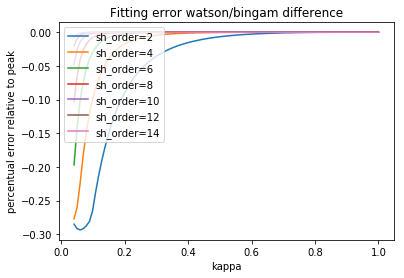

In [26]:
for i, sh_order in enumerate(sh_orders):
    plt.plot(odis, error_results_bingham_beta1[:, i] - error_results_bingham_beta0[:, i],
             label='sh_order=' + str(sh_order))
plt.title('Fitting error watson/bingam difference')
plt.xlabel('kappa')
plt.ylabel('percentual error relative to peak')
plt.legend(loc='upper left')

# What spherical harmonics order is needed to represent the data for a certain b-value. Worst case anisotropy is the stick.

In [6]:
from microstruktur.signal_models import cylinder_models
from microstruktur.core import acquisition_scheme

In [7]:
bvecs = sphere.vertices
big_delta = 0.03
small_delta = 0.01

In [8]:
# worst case scenario, completely free parallel and completely restricted perpendicular
dpar = 2.5e-9
stick1 = cylinder_models.C1Stick(mu=np.r_[0., 0.], lambda_par=dpar)
stick2 = cylinder_models.C1Stick(mu=np.r_[np.pi / 2., 0.], lambda_par=dpar)

In [9]:
sh_orders = np.arange(2, 15, 2)
bvals_list = np.linspace(0, 1e10, 100)

error_results_stick = np.zeros((len(bvals_list), len(sh_orders)))

for i, bval in enumerate(bvals_list):
    for j, sh_order in enumerate(sh_orders):
        bvals = np.tile(bval, len(bvecs))
        scheme = acquisition_scheme.acquisition_scheme_from_bvalues(
            bvalues=bvals, gradient_directions=bvecs, Delta=big_delta, delta=small_delta)
        stick_sf = 0.5 * (stick1(scheme) + stick2(scheme))
        sh_mat = real_sym_sh_mrtrix(sh_order, sphere.theta, sphere.phi)[0]
        sh_mat_inv = np.linalg.pinv(sh_mat)
        stick_sh = np.dot(sh_mat_inv, stick_sf)
        stick_rec = np.dot(sh_mat, stick_sh)
        error_results_stick[i, j] = max(np.abs(stick_sf - stick_rec) / max(stick_sf))

/user/rfick/home/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/core/acquisition_scheme.py:107: UserWarning: No b0 measurements were detected. Check if the b0_threshold option is high enough, or if there is a mistake in the acquisition design.
  warn(msg)


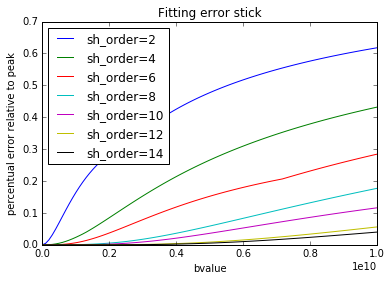

In [10]:
for i, sh_order in enumerate(sh_orders):
    plt.plot(bvals_list, error_results_stick[:, i],
             label='sh_order=' + str(sh_order))
plt.title('Fitting error stick')
plt.xlabel('bvalue')
plt.ylabel('percentual error relative to peak')
plt.legend(loc='upper left')

In [11]:
sh_order_bval = bvals_list[np.argmax(error_results_stick > 0.01, axis=0)]
sh_order_bval

array([  2.02020202e+08,   7.07070707e+08,   1.21212121e+09,
         2.52525253e+09,   3.13131313e+09,   5.35353535e+09,
         6.06060606e+09])

In [12]:
def get_sh_order_from_bval(bval):
    bvals = np.r_[2.02020202e+08,   7.07070707e+08,   1.21212121e+09,
         2.52525253e+09,   3.13131313e+09,   5.35353535e+09,
         np.inf]
    sh_orders = np.arange(2, 15, 2)
    return sh_orders[np.argmax(bvals > bval)]

In [13]:
get_sh_order_from_bval(1e9)

6

## Verify if spherical convolution is not affected

In [16]:
from microstruktur.utils.spherical_convolution import sh_convolution

In [18]:
sh_order=14
kappa=5
bvalue=1e9
sh_matrix = real_sym_sh_mrtrix(sh_order, sphere.theta, sphere.phi)[0]
rh_stick = stick1.rotational_harmonics_representation(bvalue, rh_order=sh_order)
sh_watson = watson.spherical_harmonics_representation(sh_order=sh_order, kappa=kappa, mu=[np.pi/2, 0])
sh_convolved = sh_convolution(sh_watson, rh_stick, sh_order=sh_order)
sf_convolved = np.dot(sh_matrix, sh_convolved)


sh_order_stick = get_sh_order_from_bval(bvalue)
sh_order_watson = get_sh_order_from_kappa(kappa)
rh_stick = stick1.rotational_harmonics_representation(bvalue, rh_order=sh_order_stick)
sh_watson = watson.spherical_harmonics_representation(sh_order=sh_order_watson, kappa=kappa, mu=[np.pi/2, 0])
sh_convolved2 = sh_convolution(sh_watson, rh_stick)
sh_matrix = real_sym_sh_mrtrix(np.min((sh_order_stick, sh_order_watson)), sphere.theta, sphere.phi)[0]
sf_convolved2 = np.dot(sh_matrix, sh_convolved2)

In [19]:
print sh_order_stick
print sh_order_watson

6
10


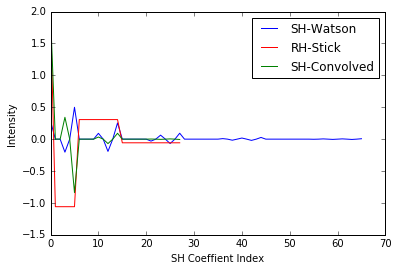

In [20]:
# plotting the sh and rh coefficients together.
# it can be seen that the convolved function is only as long as the shortest sh_order
plt.plot(sh_watson, c='b', label='SH-Watson')
plt.plot(rh_stick, c='r', label='RH-Stick')
plt.plot(sh_convolved2, c='g', label='SH-Convolved')
plt.xlabel('SH Coeffient Index')
plt.ylabel('Intensity')
plt.legend()

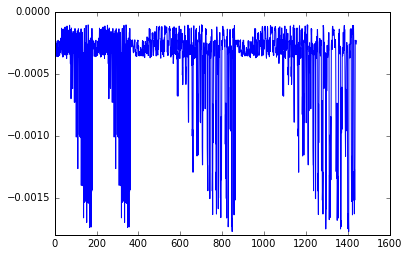

In [21]:
# comparing with original sh_order=14 implementation. Error is only around 0.1% of b0 value.
plt.plot(sf_convolved - sf_convolved2)